# Transfer Learning Template

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

    
import os, json, sys, time, random
import numpy as np
import torch
from torch.optim import Adam
from  easydict import EasyDict
import matplotlib.pyplot as plt

from steves_models.steves_ptn import Steves_Prototypical_Network

from steves_utils.lazy_iterable_wrapper import Lazy_Iterable_Wrapper
from steves_utils.iterable_aggregator import Iterable_Aggregator
from steves_utils.ptn_train_eval_test_jig import  PTN_Train_Eval_Test_Jig
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.torch_utils import get_dataset_metrics, ptn_confusion_by_domain_over_dataloader
from steves_utils.utils_v2 import (per_domain_accuracy_from_confusion, get_datasets_base_path)
from steves_utils.PTN.utils import independent_accuracy_assesment

from torch.utils.data import DataLoader

from steves_utils.stratified_dataset.episodic_accessor import Episodic_Accessor_Factory

from steves_utils.ptn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.transforms import get_chained_transform

# Allowed Parameters
These are allowed parameters, not defaults
Each of these values need to be present in the injected parameters (the notebook will raise an exception if they are not present)

Papermill uses the cell tag "parameters" to inject the real parameters below this cell.
Enable tags to see what I mean

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "seed",
    "dataset_seed",
    "n_shot",
    "n_query",
    "n_way",
    "train_k_factor",
    "val_k_factor",
    "test_k_factor",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "x_net",
    "datasets",
    "torch_default_dtype",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "x_shape",
}

In [3]:
from steves_utils.CORES.utils import (
    ALL_NODES,
    ALL_NODES_MINIMUM_1000_EXAMPLES,
    ALL_DAYS
)

from steves_utils.ORACLE.utils_v2 import (
    ALL_DISTANCES_FEET_NARROWED,
    ALL_RUNS,
    ALL_SERIAL_NUMBERS,
)

standalone_parameters = {}
standalone_parameters["experiment_name"] = "STANDALONE PTN"
standalone_parameters["lr"] = 0.001
standalone_parameters["device"] = "cuda"

standalone_parameters["seed"] = 1337
standalone_parameters["dataset_seed"] = 1337

standalone_parameters["n_way"] = 8
standalone_parameters["n_shot"] = 3
standalone_parameters["n_query"]  = 2
standalone_parameters["train_k_factor"] = 1
standalone_parameters["val_k_factor"] = 2
standalone_parameters["test_k_factor"] = 2


standalone_parameters["n_epoch"] = 50

standalone_parameters["patience"] = 10
standalone_parameters["criteria_for_best"] = "source_loss"

standalone_parameters["datasets"] = [
    {
        "labels": ALL_SERIAL_NUMBERS,
        "domains": ALL_DISTANCES_FEET_NARROWED,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "source",
        "x_transforms": ["unit_mag", "minus_two"],
        "episode_transforms": [],
        "domain_prefix": "ORACLE_"
    },
    {
        "labels": ALL_NODES,
        "domains": ALL_DAYS,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "target",
        "x_transforms": ["unit_power", "times_zero"],
        "episode_transforms": [],
        "domain_prefix": "CORES_"
    }   
]

standalone_parameters["torch_default_dtype"] = "torch.float32" 



standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
]

# Parameters relevant to results
# These parameters will basically never need to change
standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"






In [4]:
# Parameters
parameters = {
    "experiment_name": "tl_1v2:oracle.run1.framed-oracle.run2.framed",
    "device": "cuda",
    "lr": 0.0001,
    "n_shot": 3,
    "n_query": 2,
    "train_k_factor": 3,
    "val_k_factor": 2,
    "test_k_factor": 2,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "n_way": 16,
    "datasets": [
        {
            "labels": [
                "3123D52",
                "3123D65",
                "3123D79",
                "3123D80",
                "3123D54",
                "3123D70",
                "3123D7B",
                "3123D89",
                "3123D58",
                "3123D76",
                "3123D7D",
                "3123EFE",
                "3123D64",
                "3123D78",
                "3123D7E",
                "3124E4A",
            ],
            "domains": [32, 38, 8, 44, 14, 50, 20, 26],
            "num_examples_per_domain_per_label": 2000,
            "pickle_path": "/root/csc500-main/datasets/oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl",
            "source_or_target_dataset": "source",
            "x_transforms": [],
            "episode_transforms": [],
            "domain_prefix": "ORACLE.run1_",
        },
        {
            "labels": [
                "3123D52",
                "3123D65",
                "3123D79",
                "3123D80",
                "3123D54",
                "3123D70",
                "3123D7B",
                "3123D89",
                "3123D58",
                "3123D76",
                "3123D7D",
                "3123EFE",
                "3123D64",
                "3123D78",
                "3123D7E",
                "3124E4A",
            ],
            "domains": [32, 38, 8, 44, 14, 50, 20, 26],
            "num_examples_per_domain_per_label": 2000,
            "pickle_path": "/root/csc500-main/datasets/oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl",
            "source_or_target_dataset": "target",
            "x_transforms": [],
            "episode_transforms": [],
            "domain_prefix": "ORACLE.run2_",
        },
    ],
    "dataset_seed": 1337,
    "seed": 1337,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

if "x_shape" not in p:
    p.x_shape = [2,256] # Default to this if we dont supply x_shape


supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")

In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
###########################################
# The stratified datasets honor this
###########################################
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
p.domains_source = []
p.domains_target = []


train_original_source = []
val_original_source   = []
test_original_source  = []

train_original_target = []
val_original_target   = []
test_original_target  = []

In [11]:
# global_x_transform_func = lambda x: normalize(x.to(torch.get_default_dtype()), "unit_power") # unit_power, unit_mag
# global_x_transform_func = lambda x: normalize(x, "unit_power") # unit_power, unit_mag

In [12]:
def add_dataset(
    labels,
    domains,
    pickle_path,
    x_transforms,
    episode_transforms,
    domain_prefix,
    num_examples_per_domain_per_label,
    source_or_target_dataset:str,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
):
   
    if x_transforms == []: x_transform = None
    else: x_transform = get_chained_transform(x_transforms)
    
    if episode_transforms == []: episode_transform = None
    else: raise Exception("episode_transforms not implemented")
    
    episode_transform = lambda tup, _prefix=domain_prefix: (_prefix + str(tup[0]), tup[1])


    eaf = Episodic_Accessor_Factory(
        labels=labels,
        domains=domains,
        num_examples_per_domain_per_label=num_examples_per_domain_per_label,
        iterator_seed=iterator_seed,
        dataset_seed=dataset_seed,
        n_shot=n_shot,
        n_way=n_way,
        n_query=n_query,
        train_val_test_k_factors=train_val_test_k_factors,
        pickle_path=pickle_path,
        x_transform_func=x_transform,
    )

    train, val, test = eaf.get_train(), eaf.get_val(), eaf.get_test()
    train = Lazy_Iterable_Wrapper(train, episode_transform)
    val = Lazy_Iterable_Wrapper(val, episode_transform)
    test = Lazy_Iterable_Wrapper(test, episode_transform)

    if source_or_target_dataset=="source":
        train_original_source.append(train)
        val_original_source.append(val)
        test_original_source.append(test)

        p.domains_source.extend(
            [domain_prefix + str(u) for u in domains]
        )
    elif source_or_target_dataset=="target":
        train_original_target.append(train)
        val_original_target.append(val)
        test_original_target.append(test)
        p.domains_target.extend(
            [domain_prefix + str(u) for u in domains]
        )
    else:
        raise Exception(f"invalid source_or_target_dataset: {source_or_target_dataset}")
    

In [13]:
for ds in p.datasets:
    add_dataset(**ds)

In [14]:
# from steves_utils.CORES.utils import (
#     ALL_NODES,
#     ALL_NODES_MINIMUM_1000_EXAMPLES,
#     ALL_DAYS
# )

# add_dataset(
#     labels=ALL_NODES,
#     domains = ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"cores_{u}"
# )

In [15]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle1_{u}"
# )


In [16]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62,56}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle2_{u}"
# )

In [17]:
# add_dataset(
#     labels=list(range(19)),
#     domains = [0,1,2],
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "metehan.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"met_{u}"
# )

In [18]:
# # from steves_utils.wisig.utils import (
# #     ALL_NODES_MINIMUM_100_EXAMPLES,
# #     ALL_NODES_MINIMUM_500_EXAMPLES,
# #     ALL_NODES_MINIMUM_1000_EXAMPLES,
# #     ALL_DAYS
# # )

# import steves_utils.wisig.utils as wisig


# add_dataset(
#     labels=wisig.ALL_NODES_MINIMUM_100_EXAMPLES,
#     domains = wisig.ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "wisig.node3-19.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"wisig_{u}"
# )

In [19]:
###################################
# Build the dataset
###################################
train_original_source = Iterable_Aggregator(train_original_source, p.seed)
val_original_source = Iterable_Aggregator(val_original_source, p.seed)
test_original_source = Iterable_Aggregator(test_original_source, p.seed)


train_original_target = Iterable_Aggregator(train_original_target, p.seed)
val_original_target = Iterable_Aggregator(val_original_target, p.seed)
test_original_target = Iterable_Aggregator(test_original_target, p.seed)

# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Iterable_Wrapper. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[1] # Original is (<domain>, <episode>) so we strip down to episode only

train_processed_source = Lazy_Iterable_Wrapper(train_original_source, transform_lambda)
val_processed_source   = Lazy_Iterable_Wrapper(val_original_source, transform_lambda)
test_processed_source  = Lazy_Iterable_Wrapper(test_original_source, transform_lambda)

train_processed_target = Lazy_Iterable_Wrapper(train_original_target, transform_lambda)
val_processed_target   = Lazy_Iterable_Wrapper(val_original_target, transform_lambda)
test_processed_target  = Lazy_Iterable_Wrapper(test_original_target, transform_lambda)

datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [20]:
from steves_utils.transforms import get_average_magnitude, get_average_power

print(set([u for u,_ in val_original_source]))
print(set([u for u,_ in val_original_target]))

s_x, s_y, q_x, q_y, _ = next(iter(train_processed_source))
print(s_x)

# for ds in [
#     train_processed_source,
#     val_processed_source,
#     test_processed_source,
#     train_processed_target,
#     val_processed_target,
#     test_processed_target
# ]:
#     for s_x, s_y, q_x, q_y, _ in ds:
#         for X in (s_x, q_x):
#             for x in X:
#                 assert np.isclose(get_average_magnitude(x.numpy()), 1.0)
#                 assert np.isclose(get_average_power(x.numpy()), 1.0)
                

{'ORACLE.run1_20', 'ORACLE.run1_50', 'ORACLE.run1_38', 'ORACLE.run1_8', 'ORACLE.run1_26', 'ORACLE.run1_44', 'ORACLE.run1_14', 'ORACLE.run1_32'}


{'ORACLE.run2_20', 'ORACLE.run2_38', 'ORACLE.run2_8', 'ORACLE.run2_32', 'ORACLE.run2_50', 'ORACLE.run2_44', 'ORACLE.run2_14', 'ORACLE.run2_26'}


tensor([[[-0.0003,  0.0038, -0.0004,  ..., -0.0031, -0.0009, -0.0018],
         [-0.0021, -0.0010,  0.0035,  ...,  0.0008, -0.0047, -0.0016]],

        [[-0.0015,  0.0022,  0.0018,  ..., -0.0041, -0.0038, -0.0004],
         [-0.0037, -0.0010,  0.0036,  ...,  0.0013, -0.0005,  0.0040]],

        [[ 0.0021, -0.0012, -0.0025,  ...,  0.0026,  0.0045,  0.0011],
         [ 0.0027,  0.0022, -0.0029,  ..., -0.0025,  0.0015, -0.0038]],

        ...,

        [[ 0.0048, -0.0012, -0.0057,  ...,  0.0031,  0.0048, -0.0031],
         [ 0.0027,  0.0034, -0.0018,  ..., -0.0047, -0.0030, -0.0054]],

        [[ 0.0001, -0.0048,  0.0014,  ...,  0.0043,  0.0023,  0.0052],
         [ 0.0038,  0.0020, -0.0055,  ..., -0.0006,  0.0061, -0.0011]],

        [[ 0.0023,  0.0016, -0.0035,  ..., -0.0022,  0.0060,  0.0049],
         [-0.0020,  0.0053, -0.0002,  ..., -0.0052, -0.0003, -0.0012]]])


In [21]:
###################################
# Build the model
###################################
# easfsl only wants a tuple for the shape
model = Steves_Prototypical_Network(x_net, device=p.device, x_shape=tuple(p.x_shape))
optimizer = Adam(params=model.parameters(), lr=p.lr)

(2, 256)


In [22]:
###################################
# train
###################################
jig = PTN_Train_Eval_Test_Jig(model, p.BEST_MODEL_PATH, p.device)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    patience=p.patience,
    optimizer=optimizer,
    criteria_for_best=p.criteria_for_best,
)

epoch: 1, [batch: 1 / 6720], examples_per_second: 33.5030, train_label_loss: 2.8228, 


epoch: 1, [batch: 672 / 6720], examples_per_second: 2883.5956, train_label_loss: 0.6830, 


epoch: 1, [batch: 1344 / 6720], examples_per_second: 2671.4868, train_label_loss: 0.4555, 


epoch: 1, [batch: 2016 / 6720], examples_per_second: 2334.1794, train_label_loss: 0.2466, 


epoch: 1, [batch: 2688 / 6720], examples_per_second: 2298.4789, train_label_loss: 0.2682, 


epoch: 1, [batch: 3360 / 6720], examples_per_second: 2321.3771, train_label_loss: 0.1685, 


epoch: 1, [batch: 4032 / 6720], examples_per_second: 2495.3192, train_label_loss: 0.3928, 


epoch: 1, [batch: 4704 / 6720], examples_per_second: 2543.0956, train_label_loss: 0.4085, 


epoch: 1, [batch: 5376 / 6720], examples_per_second: 2623.0744, train_label_loss: 0.1623, 


epoch: 1, [batch: 6048 / 6720], examples_per_second: 2613.8797, train_label_loss: 0.0980, 


epoch: 1, source_val_acc_label: 0.6115, target_val_acc_label: 0.5940, source_val_label_loss: 108.5831, target_val_label_loss: 119.6114, 


New best


epoch: 2, [batch: 1 / 6720], examples_per_second: 2.4772, train_label_loss: 197.5786, 


epoch: 2, [batch: 672 / 6720], examples_per_second: 2762.1610, train_label_loss: 0.7388, 


epoch: 2, [batch: 1344 / 6720], examples_per_second: 2688.8885, train_label_loss: 0.3736, 


epoch: 2, [batch: 2016 / 6720], examples_per_second: 2326.9751, train_label_loss: 0.5443, 


epoch: 2, [batch: 2688 / 6720], examples_per_second: 2318.6474, train_label_loss: 0.3782, 


epoch: 2, [batch: 3360 / 6720], examples_per_second: 2328.8044, train_label_loss: 0.1497, 


epoch: 2, [batch: 4032 / 6720], examples_per_second: 2325.1920, train_label_loss: 0.2637, 


epoch: 2, [batch: 4704 / 6720], examples_per_second: 2309.1027, train_label_loss: 0.1701, 


epoch: 2, [batch: 5376 / 6720], examples_per_second: 2312.4774, train_label_loss: 0.2748, 


epoch: 2, [batch: 6048 / 6720], examples_per_second: 2336.4378, train_label_loss: 0.6734, 


epoch: 2, source_val_acc_label: 0.9061, target_val_acc_label: 0.9014, source_val_label_loss: 0.2715, target_val_label_loss: 0.3538, 


New best


epoch: 3, [batch: 1 / 6720], examples_per_second: 2.4724, train_label_loss: 0.1019, 


epoch: 3, [batch: 672 / 6720], examples_per_second: 3351.7171, train_label_loss: 0.1623, 


epoch: 3, [batch: 1344 / 6720], examples_per_second: 3424.1041, train_label_loss: 0.1775, 


epoch: 3, [batch: 2016 / 6720], examples_per_second: 3105.8560, train_label_loss: 0.2445, 


epoch: 3, [batch: 2688 / 6720], examples_per_second: 3094.4029, train_label_loss: 0.2618, 


epoch: 3, [batch: 3360 / 6720], examples_per_second: 2640.3629, train_label_loss: 0.3747, 


epoch: 3, [batch: 4032 / 6720], examples_per_second: 2609.5995, train_label_loss: 0.2327, 


epoch: 3, [batch: 4704 / 6720], examples_per_second: 2607.8496, train_label_loss: 0.1705, 


epoch: 3, [batch: 5376 / 6720], examples_per_second: 2650.1775, train_label_loss: 0.1410, 


epoch: 3, [batch: 6048 / 6720], examples_per_second: 2724.7850, train_label_loss: 0.1077, 


epoch: 3, source_val_acc_label: 0.9155, target_val_acc_label: 0.9086, source_val_label_loss: 0.2338, target_val_label_loss: 0.3186, 


New best


epoch: 4, [batch: 1 / 6720], examples_per_second: 2.8127, train_label_loss: 0.1940, 


epoch: 4, [batch: 672 / 6720], examples_per_second: 3531.6966, train_label_loss: 0.1530, 


epoch: 4, [batch: 1344 / 6720], examples_per_second: 3906.7406, train_label_loss: 0.3035, 


epoch: 4, [batch: 2016 / 6720], examples_per_second: 3880.2220, train_label_loss: 0.1844, 


epoch: 4, [batch: 2688 / 6720], examples_per_second: 3429.9110, train_label_loss: 0.3402, 


epoch: 4, [batch: 3360 / 6720], examples_per_second: 3400.9313, train_label_loss: 0.2008, 


epoch: 4, [batch: 4032 / 6720], examples_per_second: 3369.7704, train_label_loss: 0.1464, 


epoch: 4, [batch: 4704 / 6720], examples_per_second: 2882.1987, train_label_loss: 0.3310, 


epoch: 4, [batch: 5376 / 6720], examples_per_second: 2622.5682, train_label_loss: 0.0576, 


epoch: 4, [batch: 6048 / 6720], examples_per_second: 2326.8631, train_label_loss: 0.1645, 


epoch: 4, source_val_acc_label: 0.9223, target_val_acc_label: 0.9151, source_val_label_loss: 0.2192, target_val_label_loss: 0.3161, 


New best


epoch: 5, [batch: 1 / 6720], examples_per_second: 2.0096, train_label_loss: 0.0983, 


epoch: 5, [batch: 672 / 6720], examples_per_second: 2541.8137, train_label_loss: 0.0995, 


epoch: 5, [batch: 1344 / 6720], examples_per_second: 2638.6635, train_label_loss: 0.4557, 


epoch: 5, [batch: 2016 / 6720], examples_per_second: 2618.5210, train_label_loss: 0.2826, 


epoch: 5, [batch: 2688 / 6720], examples_per_second: 2677.5386, train_label_loss: 0.1722, 


epoch: 5, [batch: 3360 / 6720], examples_per_second: 3239.9913, train_label_loss: 0.2157, 


epoch: 5, [batch: 4032 / 6720], examples_per_second: 3451.4063, train_label_loss: 0.0607, 


epoch: 5, [batch: 4704 / 6720], examples_per_second: 3322.3450, train_label_loss: 0.0611, 


epoch: 5, [batch: 5376 / 6720], examples_per_second: 2964.1254, train_label_loss: 0.0707, 


epoch: 5, [batch: 6048 / 6720], examples_per_second: 2950.0775, train_label_loss: 0.2227, 


epoch: 5, source_val_acc_label: 0.9323, target_val_acc_label: 0.9226, source_val_label_loss: 0.1902, target_val_label_loss: 0.2948, 


New best


epoch: 6, [batch: 1 / 6720], examples_per_second: 2.6706, train_label_loss: 0.2449, 


epoch: 6, [batch: 672 / 6720], examples_per_second: 3036.3820, train_label_loss: 0.1641, 


epoch: 6, [batch: 1344 / 6720], examples_per_second: 3016.9580, train_label_loss: 0.3807, 


epoch: 6, [batch: 2016 / 6720], examples_per_second: 2973.1288, train_label_loss: 0.0963, 


epoch: 6, [batch: 2688 / 6720], examples_per_second: 3018.7020, train_label_loss: 0.1952, 


epoch: 6, [batch: 3360 / 6720], examples_per_second: 3507.2296, train_label_loss: 0.1507, 


epoch: 6, [batch: 4032 / 6720], examples_per_second: 3441.1847, train_label_loss: 0.0989, 


epoch: 6, [batch: 4704 / 6720], examples_per_second: 3300.0720, train_label_loss: 0.5282, 


epoch: 6, [batch: 5376 / 6720], examples_per_second: 2964.3012, train_label_loss: 0.3572, 


epoch: 6, [batch: 6048 / 6720], examples_per_second: 3208.3421, train_label_loss: 0.0822, 


epoch: 6, source_val_acc_label: 0.9447, target_val_acc_label: 0.9314, source_val_label_loss: 0.1582, target_val_label_loss: 0.2788, 


New best


epoch: 7, [batch: 1 / 6720], examples_per_second: 2.2800, train_label_loss: 0.0224, 


epoch: 7, [batch: 672 / 6720], examples_per_second: 2570.1704, train_label_loss: 0.1620, 


epoch: 7, [batch: 1344 / 6720], examples_per_second: 2573.0002, train_label_loss: 0.0094, 


epoch: 7, [batch: 2016 / 6720], examples_per_second: 2699.6837, train_label_loss: 0.0090, 


epoch: 7, [batch: 2688 / 6720], examples_per_second: 2408.9063, train_label_loss: 0.1960, 


epoch: 7, [batch: 3360 / 6720], examples_per_second: 2623.7279, train_label_loss: 0.4777, 


epoch: 7, [batch: 4032 / 6720], examples_per_second: 2610.2527, train_label_loss: 0.0913, 


epoch: 7, [batch: 4704 / 6720], examples_per_second: 2554.5804, train_label_loss: 0.2408, 


epoch: 7, [batch: 5376 / 6720], examples_per_second: 2641.2210, train_label_loss: 0.1642, 


epoch: 7, [batch: 6048 / 6720], examples_per_second: 2579.4685, train_label_loss: 0.0636, 


epoch: 7, source_val_acc_label: 0.9427, target_val_acc_label: 0.9297, source_val_label_loss: 0.1566, target_val_label_loss: 0.2681, 


epoch: 8, [batch: 1 / 6720], examples_per_second: 2.0628, train_label_loss: 0.0994, 


epoch: 8, [batch: 672 / 6720], examples_per_second: 2616.8033, train_label_loss: 0.5957, 


epoch: 8, [batch: 1344 / 6720], examples_per_second: 2573.5454, train_label_loss: 0.0207, 


epoch: 8, [batch: 2016 / 6720], examples_per_second: 2545.4252, train_label_loss: 0.0737, 


epoch: 8, [batch: 2688 / 6720], examples_per_second: 2769.7806, train_label_loss: 0.0380, 


epoch: 8, [batch: 3360 / 6720], examples_per_second: 2921.6592, train_label_loss: 0.0181, 


epoch: 8, [batch: 4032 / 6720], examples_per_second: 3080.0629, train_label_loss: 0.3368, 


epoch: 8, [batch: 4704 / 6720], examples_per_second: 2823.4218, train_label_loss: 0.2541, 


epoch: 8, [batch: 5376 / 6720], examples_per_second: 2583.0610, train_label_loss: 0.2323, 


epoch: 8, [batch: 6048 / 6720], examples_per_second: 2563.2489, train_label_loss: 0.2026, 


epoch: 8, source_val_acc_label: 0.9465, target_val_acc_label: 0.9318, source_val_label_loss: 0.1512, target_val_label_loss: 0.2766, 


New best


epoch: 9, [batch: 1 / 6720], examples_per_second: 2.0621, train_label_loss: 0.0452, 


epoch: 9, [batch: 672 / 6720], examples_per_second: 2309.5653, train_label_loss: 0.2936, 


epoch: 9, [batch: 1344 / 6720], examples_per_second: 2331.6187, train_label_loss: 0.3343, 


epoch: 9, [batch: 2016 / 6720], examples_per_second: 2314.0387, train_label_loss: 0.2895, 


epoch: 9, [batch: 2688 / 6720], examples_per_second: 2674.0769, train_label_loss: 0.1174, 


epoch: 9, [batch: 3360 / 6720], examples_per_second: 2981.5776, train_label_loss: 0.0681, 


epoch: 9, [batch: 4032 / 6720], examples_per_second: 3055.0280, train_label_loss: 0.1389, 


epoch: 9, [batch: 4704 / 6720], examples_per_second: 2597.6797, train_label_loss: 0.2400, 


epoch: 9, [batch: 5376 / 6720], examples_per_second: 2950.3074, train_label_loss: 0.1514, 


epoch: 9, [batch: 6048 / 6720], examples_per_second: 2906.5339, train_label_loss: 0.0664, 


epoch: 9, source_val_acc_label: 0.9449, target_val_acc_label: 0.9310, source_val_label_loss: 0.1515, target_val_label_loss: 0.2533, 


epoch: 10, [batch: 1 / 6720], examples_per_second: 2.3869, train_label_loss: 0.0636, 


epoch: 10, [batch: 672 / 6720], examples_per_second: 2594.0360, train_label_loss: 0.2347, 


epoch: 10, [batch: 1344 / 6720], examples_per_second: 2562.6217, train_label_loss: 0.0508, 


epoch: 10, [batch: 2016 / 6720], examples_per_second: 2610.3717, train_label_loss: 0.1669, 


epoch: 10, [batch: 2688 / 6720], examples_per_second: 2924.8043, train_label_loss: 0.0213, 


epoch: 10, [batch: 3360 / 6720], examples_per_second: 2978.4037, train_label_loss: 0.1000, 


epoch: 10, [batch: 4032 / 6720], examples_per_second: 3009.4593, train_label_loss: 0.1273, 


epoch: 10, [batch: 4704 / 6720], examples_per_second: 2637.0183, train_label_loss: 0.0304, 


epoch: 10, [batch: 5376 / 6720], examples_per_second: 2908.5217, train_label_loss: 0.3247, 


epoch: 10, [batch: 6048 / 6720], examples_per_second: 2934.3379, train_label_loss: 0.0495, 


epoch: 10, source_val_acc_label: 0.9510, target_val_acc_label: 0.9335, source_val_label_loss: 0.1382, target_val_label_loss: 0.2570, 


New best


epoch: 11, [batch: 1 / 6720], examples_per_second: 2.4389, train_label_loss: 0.0209, 


epoch: 11, [batch: 672 / 6720], examples_per_second: 2616.6496, train_label_loss: 0.1213, 


epoch: 11, [batch: 1344 / 6720], examples_per_second: 2635.6628, train_label_loss: 0.1392, 


epoch: 11, [batch: 2016 / 6720], examples_per_second: 2623.3991, train_label_loss: 0.1267, 


epoch: 11, [batch: 2688 / 6720], examples_per_second: 2953.8670, train_label_loss: 0.2595, 


epoch: 11, [batch: 3360 / 6720], examples_per_second: 3009.2049, train_label_loss: 0.0211, 


epoch: 11, [batch: 4032 / 6720], examples_per_second: 2980.9156, train_label_loss: 0.1553, 


epoch: 11, [batch: 4704 / 6720], examples_per_second: 2938.3361, train_label_loss: 0.0420, 


epoch: 11, [batch: 5376 / 6720], examples_per_second: 3160.3758, train_label_loss: 0.3456, 


epoch: 11, [batch: 6048 / 6720], examples_per_second: 3211.3302, train_label_loss: 0.1059, 


epoch: 11, source_val_acc_label: 0.9501, target_val_acc_label: 0.9316, source_val_label_loss: 0.1406, target_val_label_loss: 0.2634, 


epoch: 12, [batch: 1 / 6720], examples_per_second: 3.0130, train_label_loss: 0.2235, 


epoch: 12, [batch: 672 / 6720], examples_per_second: 3834.0153, train_label_loss: 0.1933, 


epoch: 12, [batch: 1344 / 6720], examples_per_second: 4579.6430, train_label_loss: 0.0595, 


epoch: 12, [batch: 2016 / 6720], examples_per_second: 4475.4700, train_label_loss: 0.0043, 


epoch: 12, [batch: 2688 / 6720], examples_per_second: 4425.5068, train_label_loss: 0.0156, 


epoch: 12, [batch: 3360 / 6720], examples_per_second: 4776.3594, train_label_loss: 0.1483, 


epoch: 12, [batch: 4032 / 6720], examples_per_second: 5240.3545, train_label_loss: 0.2962, 


epoch: 12, [batch: 4704 / 6720], examples_per_second: 5191.4837, train_label_loss: 0.0191, 


epoch: 12, [batch: 5376 / 6720], examples_per_second: 5024.3415, train_label_loss: 0.0295, 


epoch: 12, [batch: 6048 / 6720], examples_per_second: 5172.1501, train_label_loss: 0.0265, 


epoch: 12, source_val_acc_label: 0.9520, target_val_acc_label: 0.9341, source_val_label_loss: 0.1340, target_val_label_loss: 0.2702, 


New best


epoch: 13, [batch: 1 / 6720], examples_per_second: 5.3202, train_label_loss: 0.2525, 


epoch: 13, [batch: 672 / 6720], examples_per_second: 4018.2289, train_label_loss: 0.1711, 


epoch: 13, [batch: 1344 / 6720], examples_per_second: 3917.2870, train_label_loss: 0.0784, 


epoch: 13, [batch: 2016 / 6720], examples_per_second: 3942.3181, train_label_loss: 0.2293, 


epoch: 13, [batch: 2688 / 6720], examples_per_second: 3655.1139, train_label_loss: 0.1066, 


epoch: 13, [batch: 3360 / 6720], examples_per_second: 2993.4148, train_label_loss: 0.1219, 


epoch: 13, [batch: 4032 / 6720], examples_per_second: 2957.8224, train_label_loss: 0.3698, 


epoch: 13, [batch: 4704 / 6720], examples_per_second: 2972.8500, train_label_loss: 0.0200, 


epoch: 13, [batch: 5376 / 6720], examples_per_second: 3035.6889, train_label_loss: 0.0505, 


epoch: 13, [batch: 6048 / 6720], examples_per_second: 3030.4282, train_label_loss: 0.1555, 


epoch: 13, source_val_acc_label: 0.9529, target_val_acc_label: 0.9363, source_val_label_loss: 0.1363, target_val_label_loss: 0.2752, 


New best


epoch: 14, [batch: 1 / 6720], examples_per_second: 2.9878, train_label_loss: 0.2366, 


epoch: 14, [batch: 672 / 6720], examples_per_second: 3192.8265, train_label_loss: 0.0303, 


epoch: 14, [batch: 1344 / 6720], examples_per_second: 3190.8879, train_label_loss: 0.1341, 


epoch: 14, [batch: 2016 / 6720], examples_per_second: 3496.3948, train_label_loss: 0.1409, 


epoch: 14, [batch: 2688 / 6720], examples_per_second: 3514.3883, train_label_loss: 0.2160, 


epoch: 14, [batch: 3360 / 6720], examples_per_second: 3061.7159, train_label_loss: 0.0236, 


epoch: 14, [batch: 4032 / 6720], examples_per_second: 3009.8233, train_label_loss: 0.2531, 


epoch: 14, [batch: 4704 / 6720], examples_per_second: 3002.1642, train_label_loss: 0.0424, 


epoch: 14, [batch: 5376 / 6720], examples_per_second: 2651.0954, train_label_loss: 0.1449, 


epoch: 14, [batch: 6048 / 6720], examples_per_second: 2324.9896, train_label_loss: 0.0704, 


epoch: 14, source_val_acc_label: 0.9519, target_val_acc_label: 0.9334, source_val_label_loss: 0.1353, target_val_label_loss: 0.2644, 


epoch: 15, [batch: 1 / 6720], examples_per_second: 2.1911, train_label_loss: 0.0317, 


epoch: 15, [batch: 672 / 6720], examples_per_second: 2360.7394, train_label_loss: 0.0373, 


epoch: 15, [batch: 1344 / 6720], examples_per_second: 2405.8396, train_label_loss: 0.0933, 


epoch: 15, [batch: 2016 / 6720], examples_per_second: 2637.1299, train_label_loss: 0.0408, 


epoch: 15, [batch: 2688 / 6720], examples_per_second: 2545.5701, train_label_loss: 0.0541, 


epoch: 15, [batch: 3360 / 6720], examples_per_second: 2504.7115, train_label_loss: 0.2175, 


epoch: 15, [batch: 4032 / 6720], examples_per_second: 2313.1322, train_label_loss: 0.1252, 


epoch: 15, [batch: 4704 / 6720], examples_per_second: 2293.4605, train_label_loss: 0.2815, 


epoch: 15, [batch: 5376 / 6720], examples_per_second: 2292.9831, train_label_loss: 0.0555, 


epoch: 15, [batch: 6048 / 6720], examples_per_second: 2305.1803, train_label_loss: 0.3163, 


epoch: 15, source_val_acc_label: 0.9534, target_val_acc_label: 0.9359, source_val_label_loss: 0.1311, target_val_label_loss: 0.2670, 


epoch: 16, [batch: 1 / 6720], examples_per_second: 2.2059, train_label_loss: 0.2230, 


epoch: 16, [batch: 672 / 6720], examples_per_second: 2290.3852, train_label_loss: 0.0450, 


epoch: 16, [batch: 1344 / 6720], examples_per_second: 2396.2233, train_label_loss: 0.0658, 


epoch: 16, [batch: 2016 / 6720], examples_per_second: 2610.7533, train_label_loss: 0.0804, 


epoch: 16, [batch: 2688 / 6720], examples_per_second: 2606.5888, train_label_loss: 0.0928, 


epoch: 16, [batch: 3360 / 6720], examples_per_second: 2556.9560, train_label_loss: 0.0025, 


epoch: 16, [batch: 4032 / 6720], examples_per_second: 2321.5140, train_label_loss: 0.1903, 


epoch: 16, [batch: 4704 / 6720], examples_per_second: 2306.5868, train_label_loss: 0.0388, 


epoch: 16, [batch: 5376 / 6720], examples_per_second: 2313.8048, train_label_loss: 0.4857, 


epoch: 16, [batch: 6048 / 6720], examples_per_second: 2306.4614, train_label_loss: 0.0070, 


epoch: 16, source_val_acc_label: 0.9457, target_val_acc_label: 0.9299, source_val_label_loss: 0.1509, target_val_label_loss: 0.2809, 


epoch: 17, [batch: 1 / 6720], examples_per_second: 2.2210, train_label_loss: 0.0275, 


epoch: 17, [batch: 672 / 6720], examples_per_second: 2318.5907, train_label_loss: 0.1241, 


epoch: 17, [batch: 1344 / 6720], examples_per_second: 2321.0199, train_label_loss: 0.1344, 


epoch: 17, [batch: 2016 / 6720], examples_per_second: 2574.7947, train_label_loss: 0.0386, 


epoch: 17, [batch: 2688 / 6720], examples_per_second: 2589.0728, train_label_loss: 0.1817, 


epoch: 17, [batch: 3360 / 6720], examples_per_second: 2573.7385, train_label_loss: 0.1577, 


epoch: 17, [batch: 4032 / 6720], examples_per_second: 2279.7100, train_label_loss: 0.3392, 


epoch: 17, [batch: 4704 / 6720], examples_per_second: 2307.5344, train_label_loss: 0.1563, 


epoch: 17, [batch: 5376 / 6720], examples_per_second: 2308.3136, train_label_loss: 0.1246, 


epoch: 17, [batch: 6048 / 6720], examples_per_second: 2318.0574, train_label_loss: 0.1150, 


epoch: 17, source_val_acc_label: 0.9521, target_val_acc_label: 0.9336, source_val_label_loss: 0.1354, target_val_label_loss: 0.2713, 


Patience (3) exhausted


In [23]:
total_experiment_time_secs = time.time() - start_time_secs

In [24]:
###################################
# Evaluate the model
###################################
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = Iterable_Aggregator((datasets.source.original.val,datasets.target.original.val))

confusion = ptn_confusion_by_domain_over_dataloader(model, p.device, val_dl)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": dict(p),
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "ptn"),
}

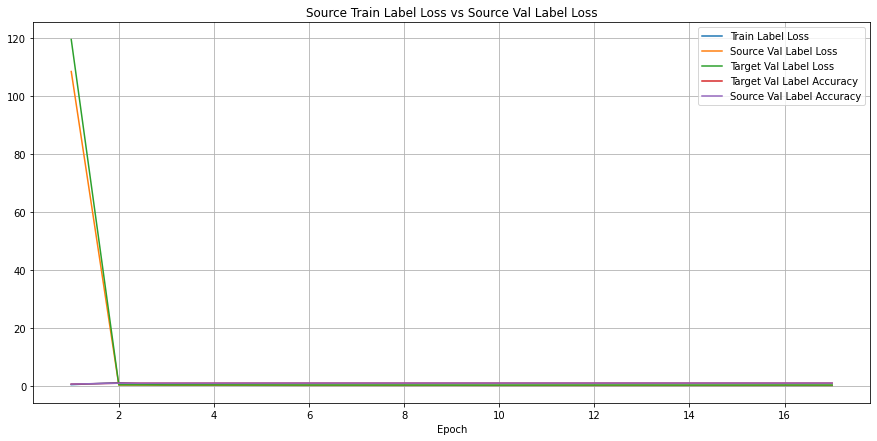

In [25]:
ax = get_loss_curve(experiment)
plt.show()

<AxesSubplot:title={'center':'Results'}>

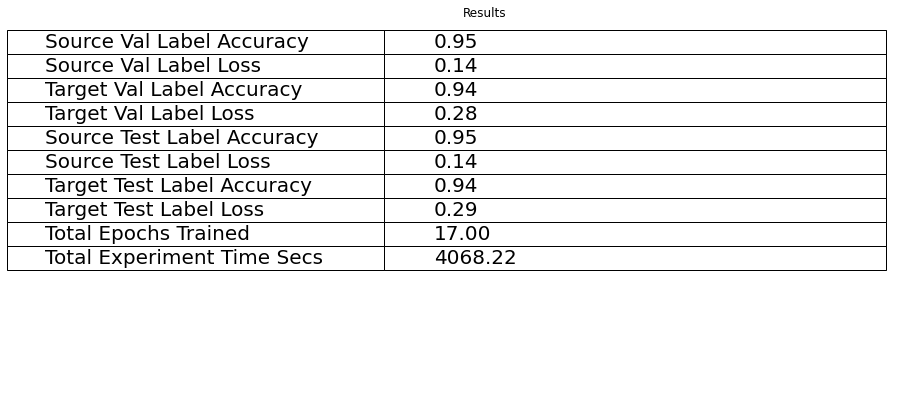

In [26]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Validation Accuracy'}, xlabel='domain'>

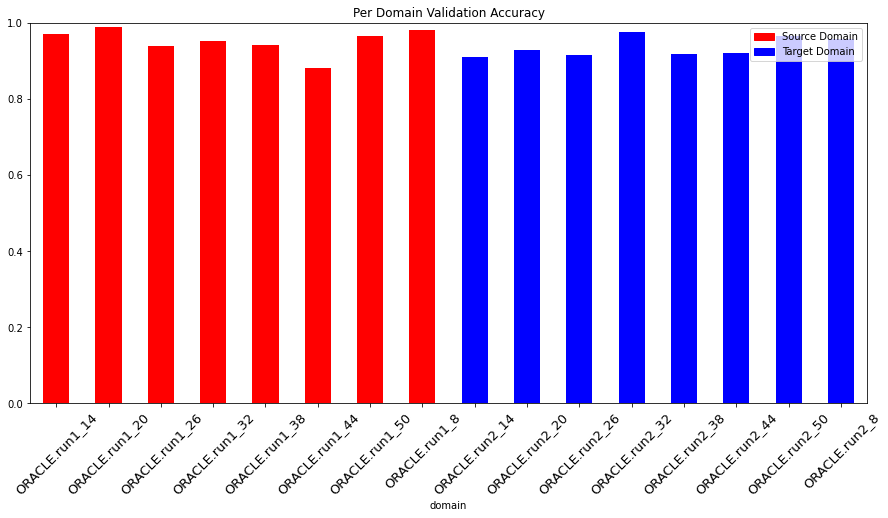

In [27]:
get_domain_accuracies(experiment)

In [28]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.95361328125 Target Test Label Accuracy: 0.9376627604166666
Source Val Label Accuracy: 0.9528645833333333 Target Val Label Accuracy: 0.9362630208333333


In [29]:
json.dumps(experiment)

'{"experiment_name": "tl_1v2:oracle.run1.framed-oracle.run2.framed", "parameters": {"experiment_name": "tl_1v2:oracle.run1.framed-oracle.run2.framed", "device": "cuda", "lr": 0.0001, "n_shot": 3, "n_query": 2, "train_k_factor": 3, "val_k_factor": 2, "test_k_factor": 2, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_accuracy", "x_net": [{"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}}, {"class": "Conv2d", "kargs": {"in_channels": 1, "out_channels": 256, "kernel_size": [1, 7], "bias": false, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 256}}, {"class": "Conv2d", "kargs": {"in_channels": 256, "out_channels": 80, "kernel_size": [2, 7], "bias": true, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 80}}, {"class": "Flatten", "kargs": {}}, {"class": "Linear", "kargs": {"in_features": 2048